# KIC818 lightcurve preparation for new CB search trials

In [56]:
import numpy as np
import matplotlib.pyplot as p
import kepselfflatten as ksf
from astropy.io import fits
import funcs

%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
#take in lightcurve data

lc = fits.open('Lightcurves/KIC818_llc_jnd.fits')
time = lc[1].data['TIME']+2454833. - 2455000.
flux = lc[1].data['PDCSAP_FLUX']
sapflux = lc[1].data['SAP_FLUX']
err = lc[1].data['PDCSAP_FLUX_ERR']
nancheck = np.isnan(time) | np.isnan(flux) | np.isnan(err)
time, flux, err, sapflux = time[~nancheck], flux[~nancheck], err[~nancheck], sapflux[~nancheck]
sort = np.argsort(time)
time, flux, err, sapflux = time[sort],flux[sort], err[sort], sapflux[sort]

lc_s = fits.open('Lightcurves/KIC818_slc_jnd.fits')
time_s = lc_s[1].data['TIME']+2454833. - 2455000.
flux_s = lc_s[1].data['PDCSAP_FLUX']
sapflux_s = lc_s[1].data['SAP_FLUX']
err_s = lc_s[1].data['PDCSAP_FLUX_ERR']
nancheck = np.isnan(time_s) | np.isnan(flux_s) | np.isnan(err_s)
time_s, flux_s, err_s, sapflux_s = time_s[~nancheck], flux_s[~nancheck], err_s[~nancheck], sapflux_s[~nancheck]
sort = np.argsort(time_s)
time_s, flux_s, err_s, sapflux_s = time_s[sort],flux_s[sort], err_s[sort], sapflux_s[sort]

t0_b = 2455189.6208722937 - 2455000.
p_b = 5.8031267986

/Users/davidarmstrong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: ResourceWarning: unclosed file <_io.FileIO name='Lightcurves/KIC818_llc_jnd.fits' mode='rb' closefd=True>
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/davidarmstrong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: ResourceWarning: unclosed file <_io.FileIO name='Lightcurves/KIC818_slc_jnd.fits' mode='rb' closefd=True>
  del sys.path[0]


<IPython.core.display.Javascript object>


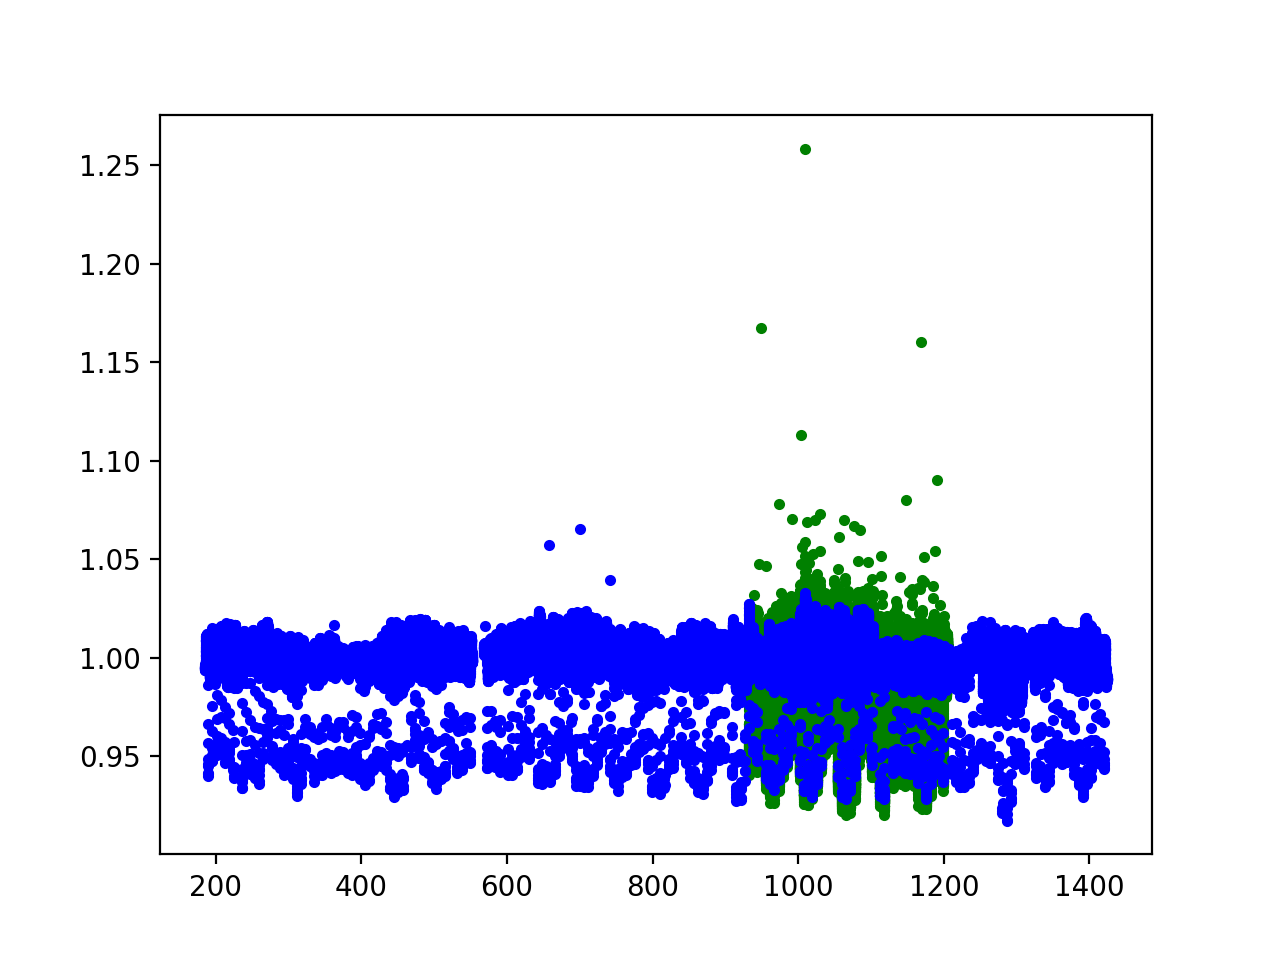

<IPython.core.display.Javascript object>


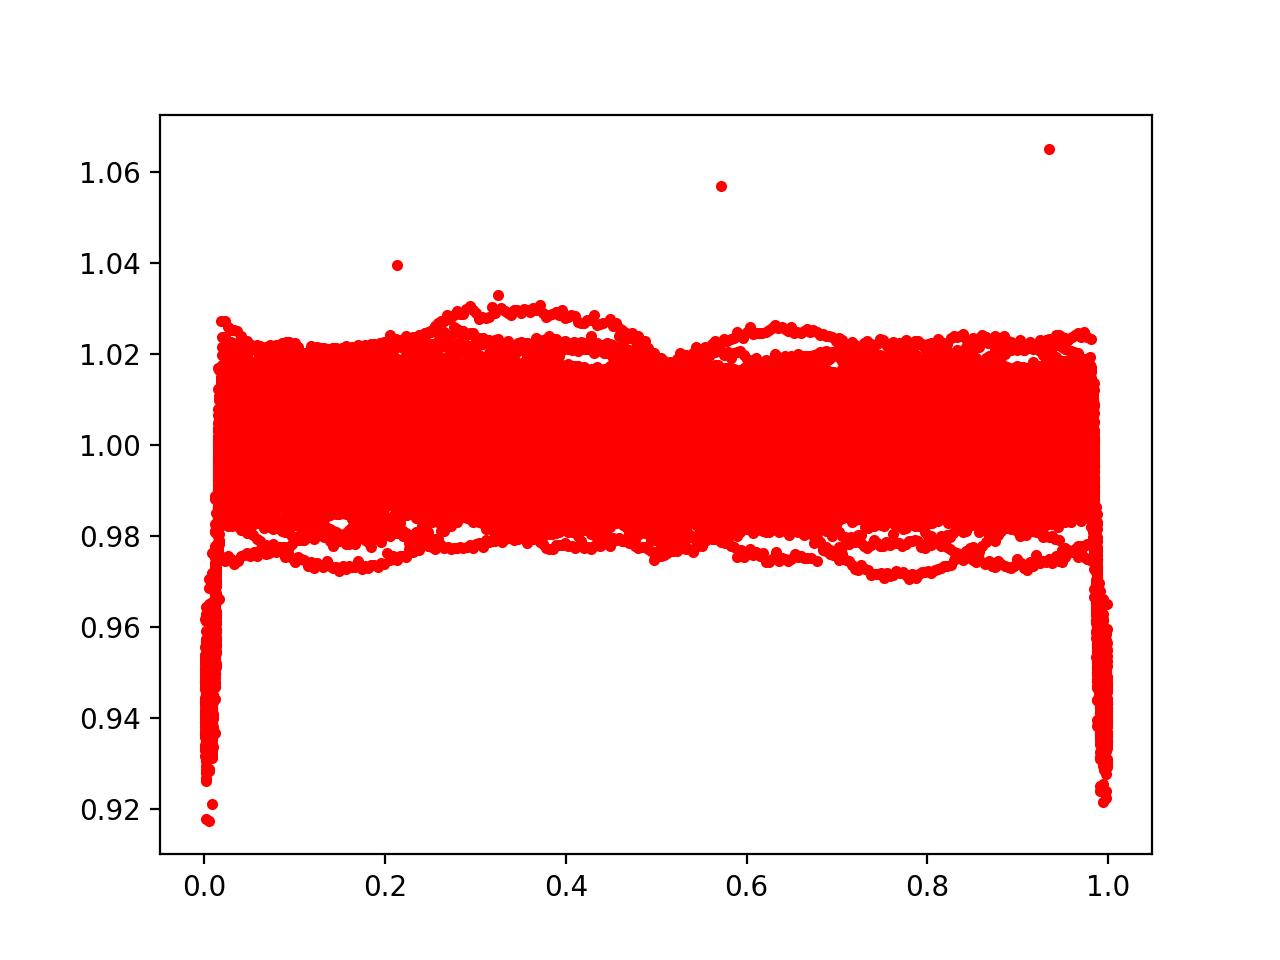

In [58]:
p.figure()
p.plot(time_s,flux_s,'g.')

p.plot(time,flux,'b.')
#p.plot(time,sapflux,'r.')
#quarter-stitched, but otherwise messy, lightcurve
p.figure()
phase = np.mod(time-t0_b,p_b)/p_b
p.plot(phase,flux,'r.')


<IPython.core.display.Javascript object>


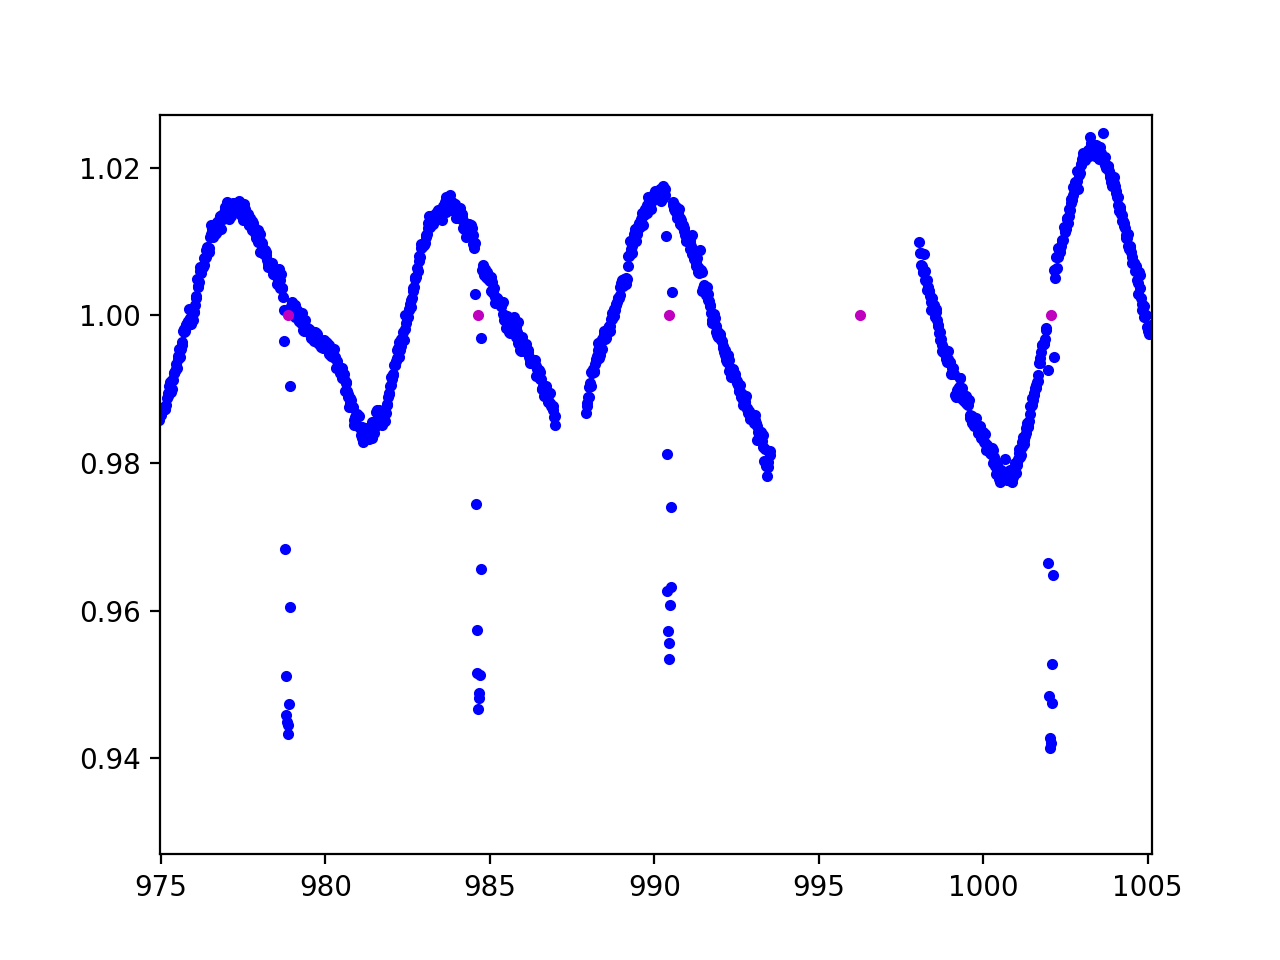

In [59]:
phase_sec = 0.51


neclipses = np.ceil((time[-1]-time[0])/p_b)
primarytimes = np.arange(neclipses)*p_b + t0_b
sectimes = np.arange(neclipses)*p_b + t0_b + phase_sec*p_b
transittimes = np.array([305.2,584.1,862.9,1141.9,1420.8])#+2455000

p.figure()
p.plot(time,flux,'b.')
p.plot(primarytimes,np.ones(len(primarytimes)),'m.')

In [62]:
#define manual transit regions (poss including binary eclipse) - define region to exclude, and baseline
# transit 1: exclude [305.06,305.38] [305.56,305.78], keep 304.2 to 306.2, including bit in middle
# transit 2: exclude [583.96,584.33], keep  583.78  to 584.56 (might be too few points?)
# transit 3: exclude [862.68,863.12], keep 862.44 to 863.93
# transit 4: exclude [1141.236,1141.43] [1141.745, 1142.08], keep 1140.35 to 1142.45, including bit in middle
# transit 5: exclude [1419.5, 1420.0] [1420.575, 1420.97], keep 1420.0 to 1421.4. drop binary eclipse, it's half in gap


tran_fit = np.array([[304.2,306.2],[583.78,584.56],[862.44,863.93],[1140.35,1142.45],[1420.,1421.4]])
#tran_fit += 2455000
tran_cut = np.array([[305.06,305.38,305.56,305.78],[583.96,584.33,0,0],[862.68,863.12,0,0],
                               [1141.236,1141.43,1141.745,1142.08],[1419.5,1420.,1420.575,1420.97]])
#tran_cut += 2455000

window_primary = 1.5
dur_primary = 0.018*2*p_b
dur_secondary = 0.2
minpoints = 10
polydegree = 3
niter = 10
sigclip = 10.

flattimes = np.empty(0)
flatflux = np.empty(0)
flaterrs = np.empty(0)

#then run through eclipses:
for eclipse in primarytimes:
    #if eclipse<np.min(time_s) or eclipse>np.max(time_s): #then in longcadence region
    timetouse = time_s
    fluxtouse = flux_s
    errtouse = err_s
    #else: #default to short cadence
    #    timetouse = time_s
    #    fluxtouse = flux_s
    #    errtouse = err_s        
    
    if np.min(np.abs(transittimes-eclipse)) > p_b/4.: #not near transit
            
        window, fit_window = funcs.form_window(timetouse,eclipse,window_primary,dur_primary)
        
        if len(fit_window) > minpoints:
            t_offset = timetouse[window][0]
            fitdat = np.array([timetouse[fit_window]-t_offset,fluxtouse[fit_window],errtouse[fit_window]]).T
            polyparams = ksf.dopolyfit(fitdat,polydegree,niter,sigclip)
            flat = fluxtouse[window] / np.polyval(polyparams,timetouse[window]-t_offset)
            flatflux = np.hstack((flatflux,flat))
            flattimes = np.hstack((flattimes,timetouse[window]))
            flaterrs = np.hstack((flaterrs,errtouse[window]))
    
    else:
        tidx = np.argmin(np.abs(transittimes-eclipse))
        s_window = np.searchsorted(timetouse,tran_fit[tidx,0])
        e_window = np.searchsorted(timetouse,tran_fit[tidx,1])
        indices = np.arange(e_window+1)
        window = indices[s_window:e_window]
        if len(window)>minpoints:
            t_offset = timetouse[window][0]
        
            ncuts = int(np.sum(tran_cut[tidx]>0)/2)
            if ncuts==1:
                s_cut = np.searchsorted(timetouse,tran_cut[tidx,0])
                e_cut = np.searchsorted(timetouse,tran_cut[tidx,1])
                fit_window = np.hstack((indices[s_window:s_cut],indices[e_cut:e_window]))         
            else: #only works for ncuts=2
                s_cut1 = np.searchsorted(timetouse,tran_cut[tidx,0])
                e_cut1 = np.searchsorted(timetouse,tran_cut[tidx,1])
                s_cut2 = np.searchsorted(timetouse,tran_cut[tidx,2])
                e_cut2 = np.searchsorted(timetouse,tran_cut[tidx,3])
                fit_window = np.hstack((indices[s_window:s_cut1],indices[e_cut1:s_cut2],indices[e_cut2:e_window]))
   
            fitdat = np.array([timetouse[fit_window]-t_offset,fluxtouse[fit_window],errtouse[fit_window]]).T
            polyparams = ksf.dopolyfit(fitdat,polydegree,niter,sigclip)
            flat = fluxtouse[window] / np.polyval(polyparams,timetouse[window]-t_offset)
            flatflux = np.hstack((flatflux,flat))
            flattimes = np.hstack((flattimes,timetouse[window]))
            flaterrs = np.hstack((flaterrs,errtouse[window]))
                 
        
for eclipse in sectimes:
    #if eclipse<np.min(time_s) or eclipse>np.max(time_s):
    timetouse = time_s
    fluxtouse = flux_s
    errtouse = err_s
    #else:
    #    timetouse = time_s
    #    fluxtouse = flux_s
    #    errtouse = err_s        
    
    if np.min(np.abs(transittimes-eclipse)) > p_b/4.: #not near transit
            
        window, fit_window = funcs.form_window(timetouse,eclipse,window_primary,dur_secondary)
        
        if len(fit_window) > minpoints:
            t_offset = timetouse[window][0]
            fitdat = np.array([timetouse[fit_window]-t_offset,fluxtouse[fit_window],errtouse[fit_window]]).T
            polyparams = ksf.dopolyfit(fitdat,polydegree,niter,sigclip)
            flat = fluxtouse[window] / np.polyval(polyparams,timetouse[window]-t_offset)
            flatflux = np.hstack((flatflux,flat))
            flattimes = np.hstack((flattimes,timetouse[window]))
            flaterrs = np.hstack((flaterrs,errtouse[window]))
        
sortidx = np.argsort(np.array(flattimes))
time_f,flux_f,err_f = np.array(flattimes)[sortidx],np.array(flatflux)[sortidx],np.array(flaterrs)[sortidx]

<IPython.core.display.Javascript object>


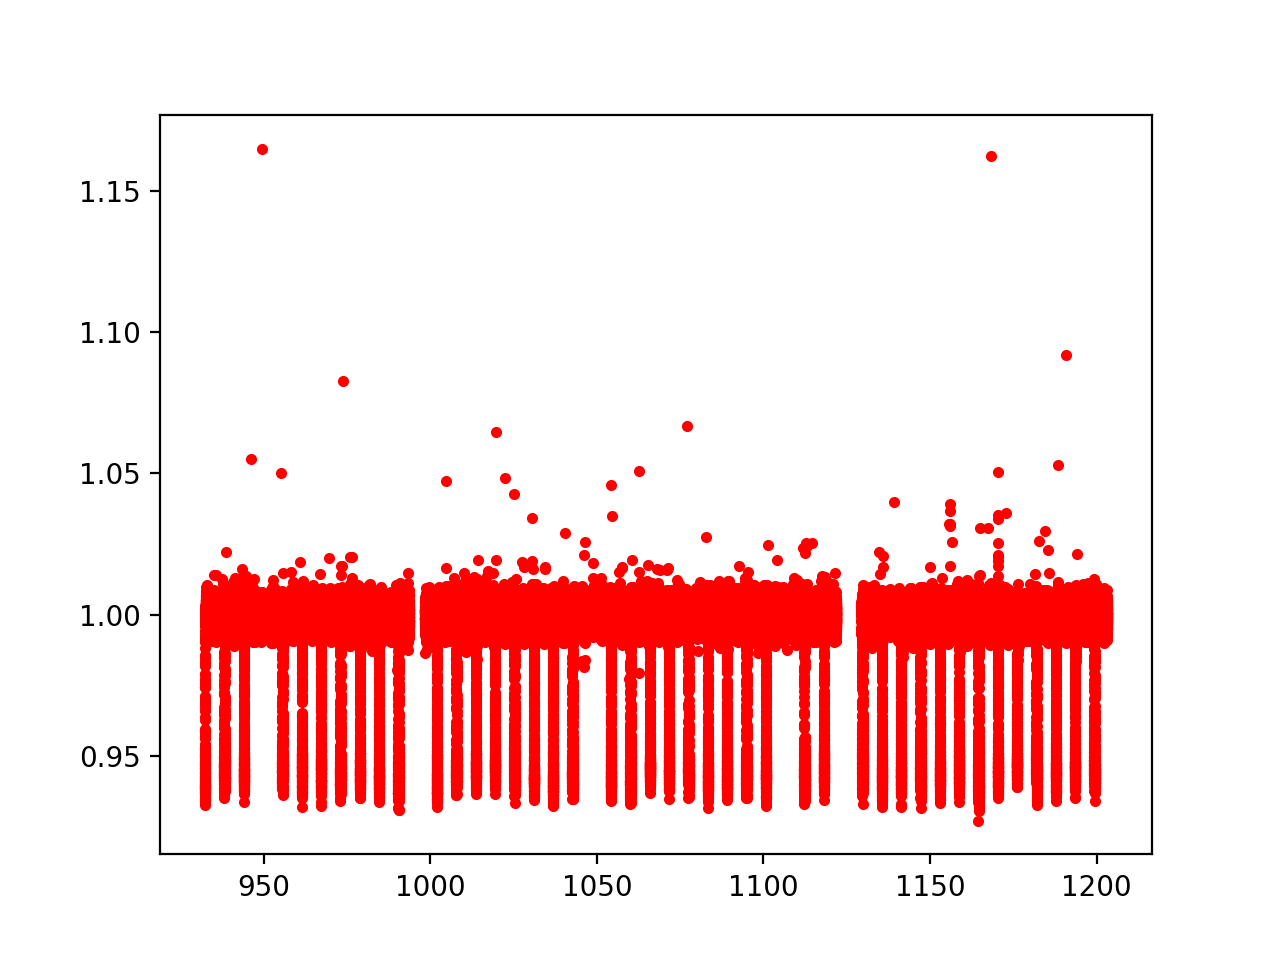

<IPython.core.display.Javascript object>


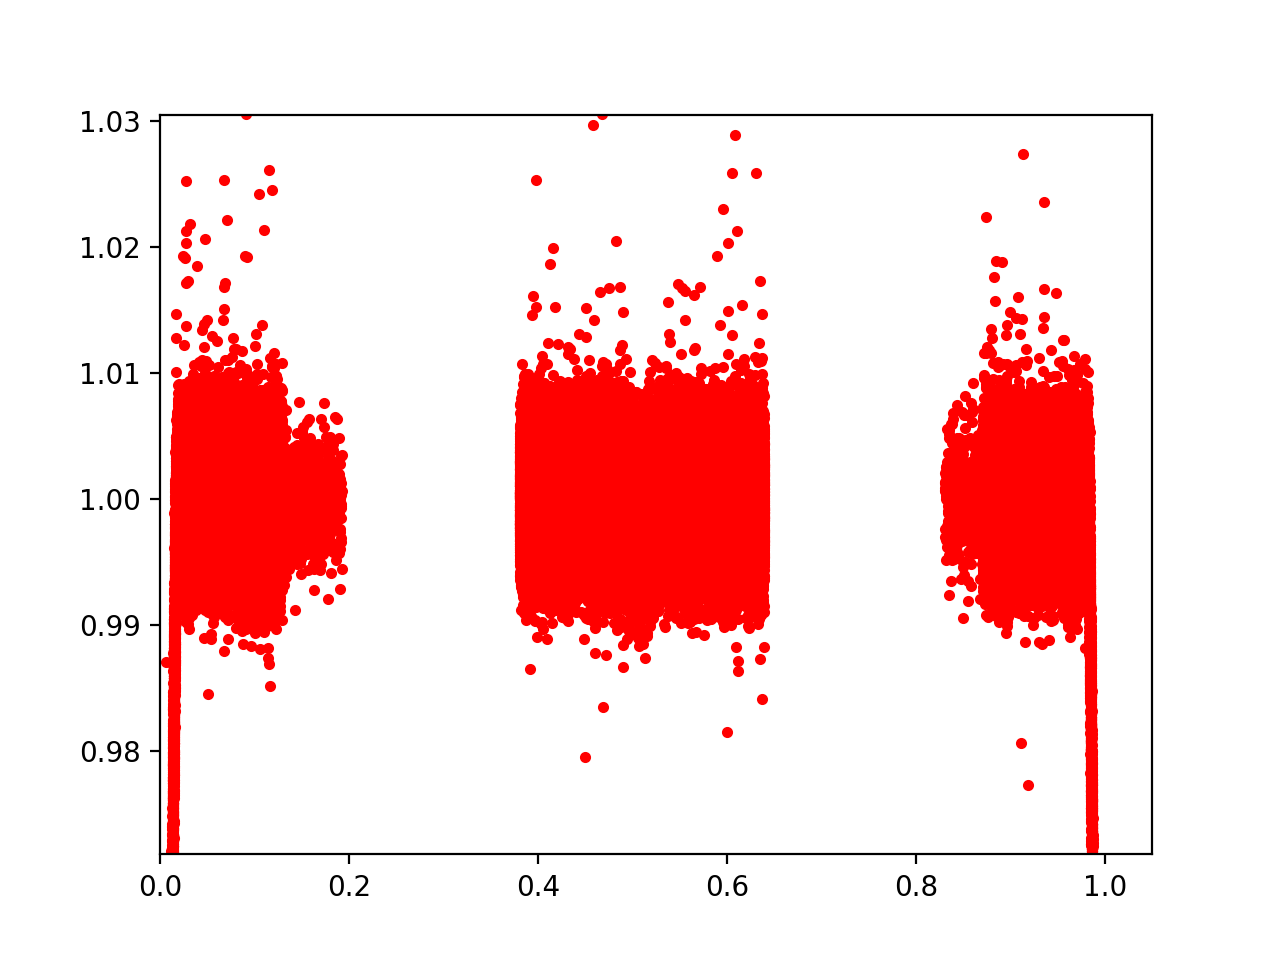

In [63]:
p.figure()
p.plot(time_f,flux_f,'r.')

p.figure()
phase = np.mod(time_f-t0_b,p_b)/p_b
p.plot(phase,flux_f,'r.')

<IPython.core.display.Javascript object>


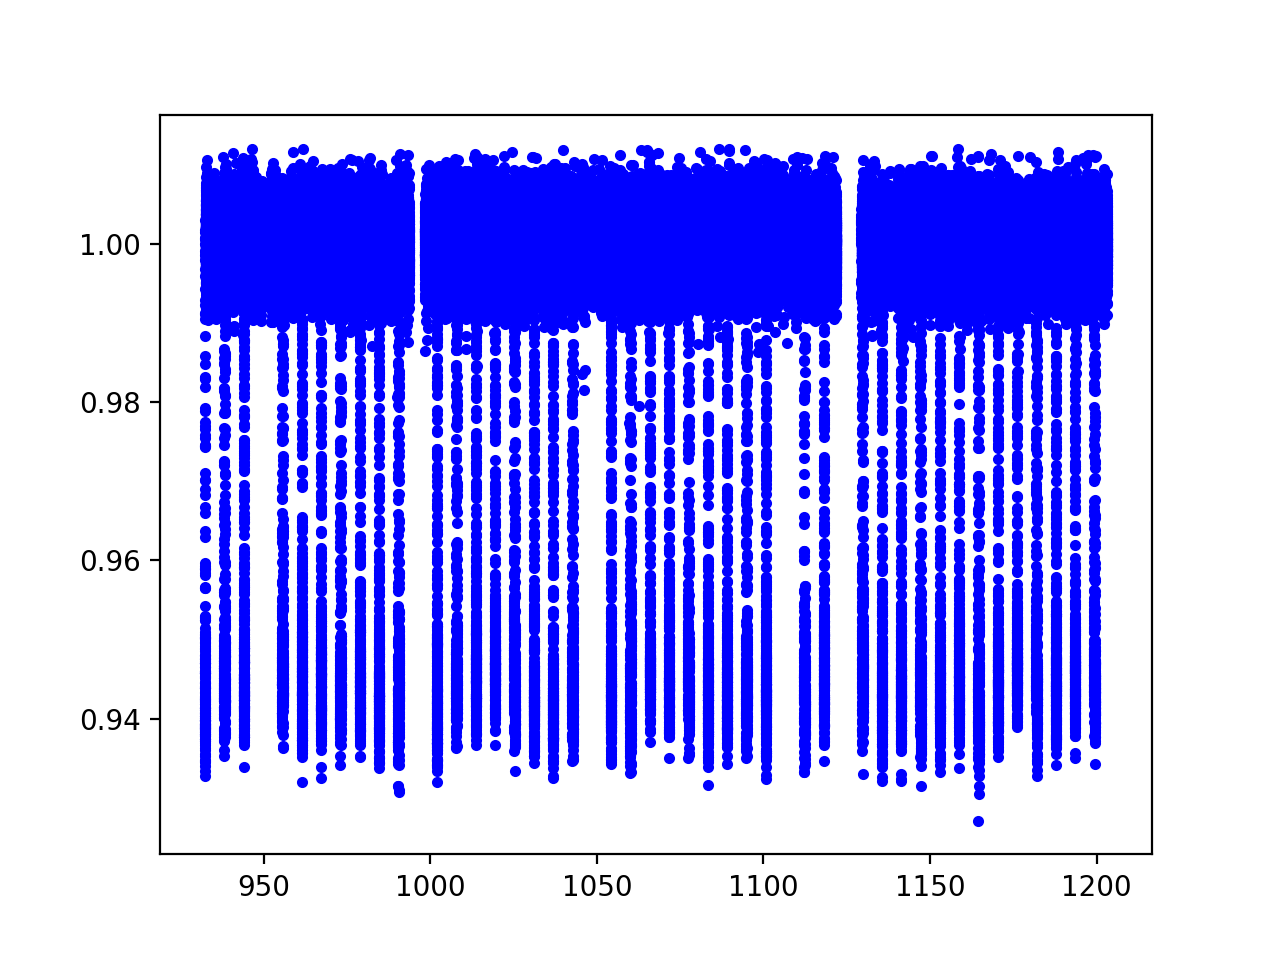

In [64]:
#remove points above 1.012
cut = flux_f<1.012
time_f,flux_f,err_f = time_f[cut],flux_f[cut],err_f[cut]


#timecut = np.min(np.where(time>135)) #removes first extra deep binary eclipse
#time, flux, err = time[timecut:], flux[timecut:], err[timecut:]

#tmin = 145.5
#tmax = 152.5
#cut = (time>tmin) & (time<tmax) & ((flux>1.002) | (flux<0.9988))
#time, flux, err = time[~cut], flux[~cut], err[~cut]

p.figure()
p.plot(time_f,flux_f,'b.')


#phase = np.mod(time-t_t0,t_per)/t_per
#p.figure()
#p.plot(phase,flux,'r.')


In [65]:
#save lightcurve for other search tests

output = np.zeros(len(time_f))
output = np.array([time_f,flux_f,err_f]).T
np.savetxt('Lightcurves/KIC818_clean_eclonly_slconly.txt',output)